<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Load-the-dataset" data-toc-modified-id="1.-Load-the-dataset-1">1. Load the dataset</a></span></li><li><span><a href="#2.-EDA" data-toc-modified-id="2.-EDA-2">2. EDA</a></span></li><li><span><a href="#3.-Feature-engineering" data-toc-modified-id="3.-Feature-engineering-3">3. Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Splitting-the-dataset" data-toc-modified-id="Splitting-the-dataset-3.1">Splitting the dataset</a></span></li><li><span><a href="#SMOTE-Sampling" data-toc-modified-id="SMOTE-Sampling-3.2">SMOTE Sampling</a></span></li></ul></li><li><span><a href="#4.-Modeling" data-toc-modified-id="4.-Modeling-4">4. Modeling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1">Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.2">Random Forest</a></span></li><li><span><a href="#XGBoosting" data-toc-modified-id="XGBoosting-4.3">XGBoosting</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4">CatBoost</a></span></li></ul></li><li><span><a href="#5.-Comparison-of-model-performances" data-toc-modified-id="5.-Comparison-of-model-performances-5">5. Comparison of model performances</a></span></li></ul></div>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from catboost import CatBoostClassifier

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float", "{:.3f}".format)
warnings.filterwarnings(action='ignore')

In [8]:
logres = pickle.load(open('logres_model.sav', 'rb'))
rf_grid = pickle.load(open('rf_model.sav', 'rb'))
xgboosting = pickle.load(open('xgb_model.sav', 'rb'))
cat_clf = pickle.load(open('cat_clf.sav', 'rb'))

In [6]:
def print_score(actual, pred, prob, split):
    print(f"\n{split} set modeling Result:")
    print("================================================")
    print(confusion_matrix(actual, pred))
    print(f"\nAccuracy Score: {round(accuracy_score(actual, pred), 5)*100}%")
    
    print(f"AU Precision-Recall curve Score: {round(average_precision_score(actual, prob), 5)}")
    print("-----------------------------------------------")
    print(classification_report(actual, pred))
    print("-----------------------------------------------")

# 1. Load the dataset

In [9]:
data = pd.read_csv('creditcard_fraud.csv')

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


# 2. EDA

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [40]:
data.shape

(284807, 31)

데이터셋은 31개의 열과 284807개의 개체로 이루어져 있습니다.

In [43]:
data.isna().sum().max()

0

결측치는 발견되지 않았습니다.

In [68]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


데이터셋의 각 변수들의 기초 통계량을 확인해 본 바에 따르면, 많은 변수들의 분포가 심하게 왜곡되어 있는 것을 확인할 수 있습니다. 익명처리된 다른 변수들은 평균 0, 표준편차 약 1 내외로 변환된 것과는 달리 Time과 Amount 변수는 추후에 Scaling이 필요해 보입니다. <br>
익명처리된 변수에 대한 정보가 없기 때문에 추가로 더 필요한 Feature engineering은 없을 것으로 보입니다.

In [58]:
data['Class'].value_counts()
print('-------------------------------')
print("No frauds:", round(data['Class'].value_counts(normalize=True)[0], 4) * 100, "% of the dataset")
print("Frauds:", round(data['Class'].value_counts(normalize=True)[1] * 100, 2), "% of the dataset")

0    284315
1       492
Name: Class, dtype: int64

-------------------------------
No frauds: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


<AxesSubplot:xlabel='Class', ylabel='count'>

Text(0.5, 1.0, 'Class distribution \n (0: No fraud, 1: Fraud)')

([<matplotlib.axis.XTick at 0x2b05a343df0>,
 [Text(0, 0, 'Non-fraud'), Text(1, 0, 'Fraud')])

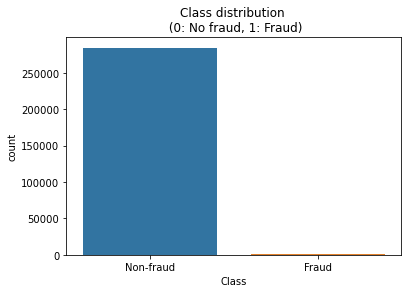

In [70]:
sns.countplot(x='Class', data=data)
plt.title("Class distribution \n (0: No fraud, 1: Fraud)")
plt.xticks(range(2), ['Non-fraud', 'Fraud'])

전체 284807개의 데이터 중 99.83%가 정상적인 사용이었으며, 오직 0.17% 만이 사기목적인 심하게 불균형한 데이터셋임을 확인할 수 있습니다.

In [ ]:
fradata['Class'] == 1

array([[<AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>],
       [<AxesSubplot:title={'center':'V5'}>,
        <AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>],
       [<AxesSubplot:title={'center':'V10'}>,
        <AxesSubplot:title={'center':'V11'}>,
        <AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>],
       [<AxesSubplot:title={'center':'V15'}>,
        <AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>,
        <AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>],
       [<AxesSubplot:title={'center':'V20'}>,
        <AxesSubplot:title={'center':'

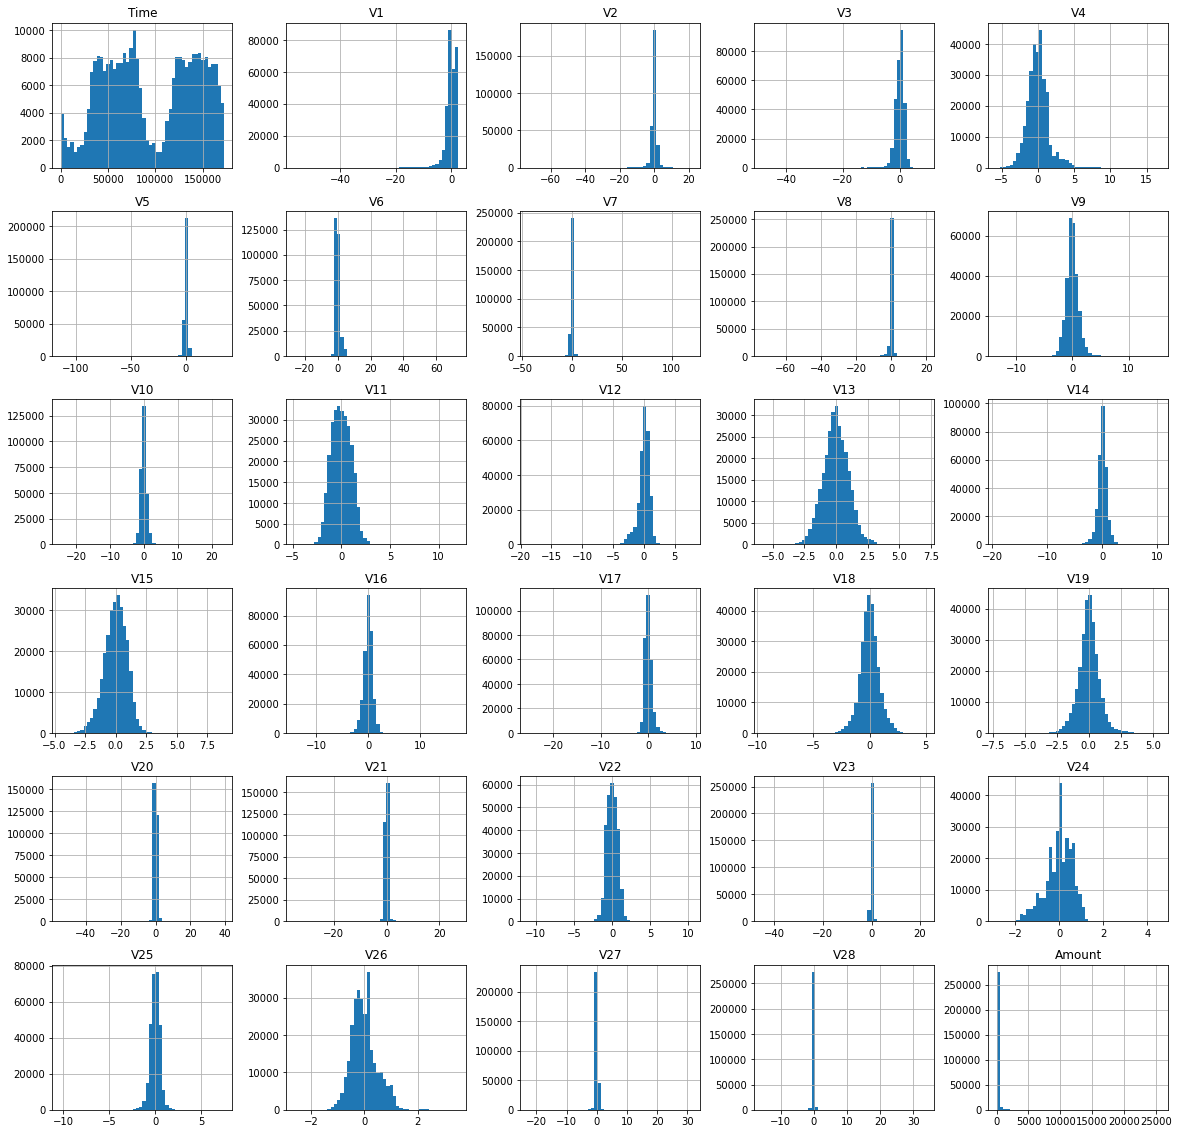

In [64]:
data.drop('Class', axis=1).hist(figsize=(20,20), bins=50)

각 독립변수들의 분포를 히스토그램을 활용하여 시각화 하였습니다. 많은 변수들이 분포가 심하게 왜곡되어 있음을 확인할 수 있습니다.

In [92]:
corr = data.corr()

<Figure size 1296x1008 with 0 Axes>

<AxesSubplot:>

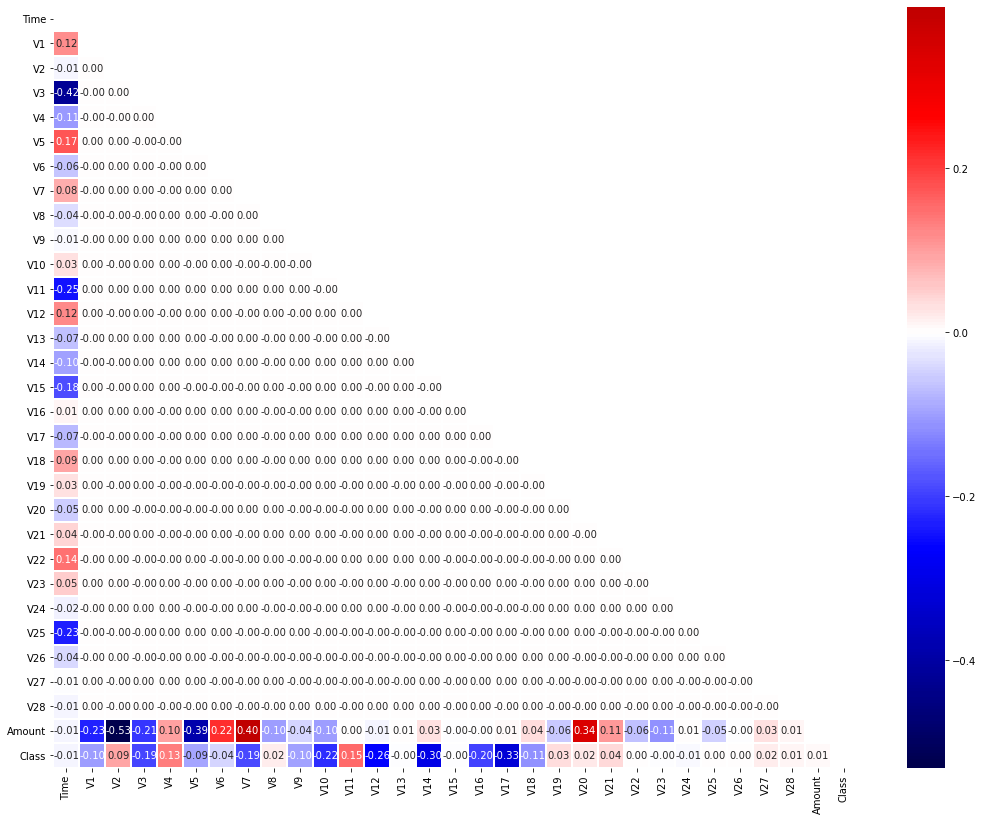

In [94]:
plt.figure(figsize=(18, 14))
mask_corr = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
           mask=mask_corr,
           annot=True,
           center=0, cmap='seismic',
           fmt='.2f',
           linewidths=1)

변수간 상관관계가 가장 높은 변수들
> Time & V3 (-0.42) <br>
> Amount & V2 (-0.53) <br>
> Amount & V4 (0.4)

이들 변수의 상관관계가 높은 편이긴 하나 다중공선성을 가질 정도로 높은 수준은 아닌 것으로 예상됩니다.

# 3. Feature engineering

## Splitting the dataset

In [10]:
X = data.drop('Class', axis=1)
y = data['Class']

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=802, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train.shape
X_test.shape

(199364, 30)

(85443, 30)

In [9]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0   0.998
1   0.002
Name: Class, dtype: float64

0   0.998
1   0.002
Name: Class, dtype: float64

데이터셋을 Training 데이터와 Test 데이터로 7:3으로 분할한 후 Scaling 하였습니다.

## SMOTE Sampling

In [11]:
smote = SMOTE()

X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='Class', ylabel='count'>

Text(0.5, 1.0, 'Before SMOTE')

<AxesSubplot:xlabel='Class', ylabel='count'>

Text(0.5, 1.0, 'After SMOTE')

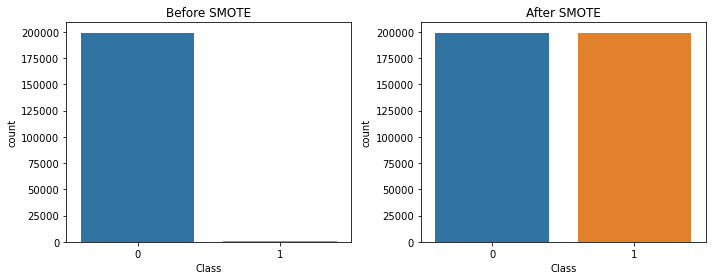

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")

sns.countplot(y_train_re, ax=axes[1])
axes[1].set_title("After SMOTE")

fig.tight_layout()

SMOTE 알고리즘을 이용하여 소수 클래스(Fraud)를 합성하여 Oversampling 하였습니다.

# 4. Modeling

## Logistic Regression

In [53]:
logres = LogisticRegression(random_state=802)

logres.fit(X_train_re, y_train_re)

pickle.dump(logres, open('logres_model.sav', 'wb'))

LogisticRegression(random_state=802)

In [12]:
# 트레이닝 데이터에 대한 모델 성과평가
print_score(y_train, logres.predict(X_train), logres.predict_proba(X_train)[:,1], "Training")


Training set modeling Result:
[[193841   5179]
 [    29    315]]

Accuracy Score: 97.38799999999999%
AU Precision-Recall curve Score: 0.72346
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    199020
           1       0.06      0.92      0.11       344

    accuracy                           0.97    199364
   macro avg       0.53      0.94      0.55    199364
weighted avg       1.00      0.97      0.99    199364

-----------------------------------------------


In [13]:
# 테스트 데이터에 대한 모델 성과평가
print_score(y_test, logres.predict(X_test), logres.predict_proba(X_test)[:,1], "Test")


Test set modeling Result:
[[83052  2243]
 [    9   139]]

Accuracy Score: 97.36399999999999%
AU Precision-Recall curve Score: 0.75338
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.94      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.96      0.55     85443
weighted avg       1.00      0.97      0.99     85443

-----------------------------------------------


In [56]:
scores_dict = {
    'Logistic regression':{
        'Train':f1_score(y_train, logres.predict(X_train)).round(2),
        'Test':f1_score(y_test, logres.predict(X_test)).round(2)
    }
}

**Performance evaluation of Logistic Regression** <br>
* 트레이닝 세트 모델링 결과
> Accuracy: 68.27% <br>
AU Precision-Recall curve: 0.723 <br>
F1: 0.11



* 테스트 세트 모델링 결과
> Accuracy: 68.223% <br>
AU Precision-Recall curve: 0.753 <br>
F1: 0.11

## Random Forest

In [26]:
rf = RandomForestClassifier(random_state=802)

param_grid_rf ={
    'n_estimators':[500],
    'max_depth':[7],
    'min_samples_leaf':[0.01]
}

rf_grid = GridSearchCV(estimator=rf,
                      param_grid=param_grid_rf,
                      cv=4,
                      scoring='roc_auc',
                      n_jobs=-1)


t0 = time.time()
rf_grid.fit(X_train_re, y_train_re)
t1 = time.time()



print(f"모델링 소요시간: {t1-t0:.2f}초")

pickle.dump(rf_grid, open('rf_model.sav', 'wb'))

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=802),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'min_samples_leaf': [0.01, 0.05],
                         'n_estimators': [500]},
             scoring='roc_auc')

모델링 소요시간: 3303.49초


In [14]:
rf_grid.best_params_
rf_best = rf_grid.best_estimator_

# 트레이닝 데이터에 대한 모델 성과평가
print_score(y_train, rf_best.predict(X_train), rf_best.predict_proba(X_train)[:, 1], "Training")

{'max_depth': 7, 'min_samples_leaf': 0.01, 'n_estimators': 500}


Training set modeling Result:
[[197214   1806]
 [    39    305]]

Accuracy Score: 99.075%
AU Precision-Recall curve Score: 0.78934
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199020
           1       0.14      0.89      0.25       344

    accuracy                           0.99    199364
   macro avg       0.57      0.94      0.62    199364
weighted avg       1.00      0.99      0.99    199364

-----------------------------------------------


In [15]:
# 테스트 데이터에 대한 모델 성과평가
print_score(y_test, rf_best.predict(X_test), rf_best.predict_proba(X_test)[:, 1], "Test")


Test set modeling Result:
[[84511   784]
 [   14   134]]

Accuracy Score: 99.066%
AU Precision-Recall curve Score: 0.81531
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.15      0.91      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.62     85443
weighted avg       1.00      0.99      0.99     85443

-----------------------------------------------


In [58]:
scores_dict['Random Forest'] = {
    'Train':f1_score(y_train, rf_best.predict(X_train)).round(2),
    'Test':f1_score(y_test, rf_best.predict(X_test)).round(2)
}

**Performance evaluation of Random Forest** <br>
* 트레이닝 세트 모델링 결과
> Accuracy: 99.075% <br>
AU Precision-Recall curve: 0.789 <br>
F1: 0.25



* 테스트 세트 모델링 결과
> Accuracy: 99.066% <br>
AU Precision-Recall curve: 0.815 <br>
F1: 0.25

## XGBoosting

In [23]:
xgboosting = xgb.XGBClassifier(objective='binary:logistic',
                               n_estimators=1000,
                               n_jobs=-1)

t0 = time.time()
xgboosting.fit(X_train_re, y_train_re)
t1 = time.time()

print(f"모델링 소요시간: {t1-t0:.2f}초")

pickle.dump(xgboosting, open('xgb_model.sav', 'wb'))

[12:55:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

모델링 소요시간: 736.74초


In [16]:
# 트레이닝 데이터에 대한 모델 성과평가
print_score(y_train, xgboosting.predict(X_train), xgboosting.predict_proba(X_train)[:,1], "Training")


Training set modeling Result:
[[199020      0]
 [     0    344]]

Accuracy Score: 100.0%
AU Precision-Recall curve Score: 1.0
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00       344

    accuracy                           1.00    199364
   macro avg       1.00      1.00      1.00    199364
weighted avg       1.00      1.00      1.00    199364

-----------------------------------------------


In [17]:
# 테스트 데이터에 대한 모델 성과평가
print_score(y_test, xgboosting.predict(X_test), xgboosting.predict_proba(X_test)[:,1], "Test")


Test set modeling Result:
[[85267    28]
 [   19   129]]

Accuracy Score: 99.945%
AU Precision-Recall curve Score: 0.8825
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.82      0.87      0.85       148

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443

-----------------------------------------------


**Performance evaluation of XGBoosting** <br>
* 트레이닝 세트 모델링 결과
> Accuracy: 100% <br>
AU Precision-Recall curve: 1.0 <br>
F1: 1.0



* 테스트 세트 모델링 결과
> Accuracy: 99.945% <br>
AU Precision-Recall curve: 0.8825 <br>
F1: 0.85

In [62]:
scores_dict['XGBoosting'] = {
    'Train':f1_score(y_train, xgboosting.predict(X_train)).round(2),
    'Test':f1_score(y_test, xgboosting.predict(X_test)).round(2)
}

## CatBoost

In [40]:
cat_clf = CatBoostClassifier(verbose=0)

t0 = time.time()
cat_clf.fit(X_train_re, y_train_re)
t1 = time.time()

print(f"모델링 소요시간: {t1-t0:.2f}초")

pickle.dump(cat_clf, open('cat_clf.sav', 'wb'))

모델링 소요시간: 82.98초


In [18]:
# 트레이닝 데이터에 대한 모델 성과평가
print_score(y_train, cat_clf.predict(X_train), cat_clf.predict_proba(X_train)[:,1], "Training")


Training set modeling Result:
[[198875    145]
 [     0    344]]

Accuracy Score: 99.92699999999999%
AU Precision-Recall curve Score: 0.99394
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.70      1.00      0.83       344

    accuracy                           1.00    199364
   macro avg       0.85      1.00      0.91    199364
weighted avg       1.00      1.00      1.00    199364

-----------------------------------------------


In [19]:
# 테스트 데이터에 대한 모델 성과평가
print_score(y_test, cat_clf.predict(X_test), cat_clf.predict_proba(X_test)[:,1], "Test")


Test set modeling Result:
[[85194   101]
 [   17   131]]

Accuracy Score: 99.862%
AU Precision-Recall curve Score: 0.87656
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.56      0.89      0.69       148

    accuracy                           1.00     85443
   macro avg       0.78      0.94      0.84     85443
weighted avg       1.00      1.00      1.00     85443

-----------------------------------------------


**Performance evaluation of CatBoost** <br>
* 트레이닝 세트 모델링 결과
> Accuracy: 99.93% <br>
AU Precision-Recall curve: 0.994 <br>
F1: 0.83



* 테스트 세트 모델링 결과
> Accuracy: 99.86% <br>
AUAU Precision-Recall curveROC: 0.876 <br>
F1: 0.85

In [63]:
scores_dict['CatBoost'] = {
    'Train':f1_score(y_train, cat_clf.predict(X_train)).round(2),
    'Test':f1_score(y_test, cat_clf.predict(X_test)).round(2)
}

# 5. Comparison of model performances

<AxesSubplot:>

Text(0.5, 1.0, 'F1 scores')

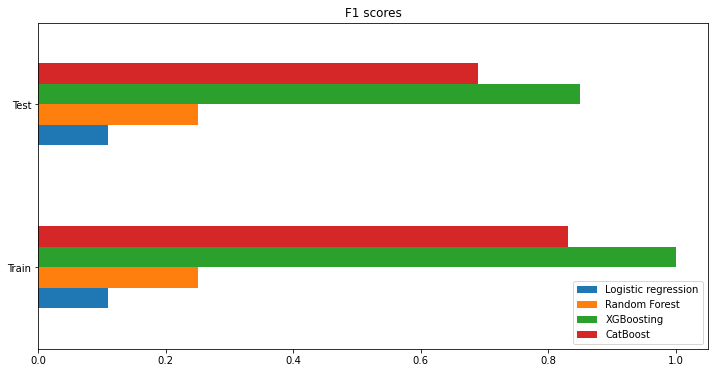

In [69]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(12, 6))
plt.title("F1 scores")